In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt      
import pickle
import pandas as pd
import seaborn as sns
from scipy import stats
from matplotlib.ticker import MultipleLocator
import matplotlib.colors as mcolors


sns.set(rc={"figure.figsize":(10, 10)})
sns.set_theme(style="white"), sns.set_style('ticks') 

NB_IMAGES = 600


NB_CONTEXT_TYPES = 10
context_to_num = {'full context': 0, 'incongruent context':1, 
                  'no context':2, 'no object':3, 'blur context':4, 
                  'blur object':5, 'blur boundary':6, 'min context':7, 
                  'jigsaw context':8, 'textured context':9}
num_to_context = {value: key for key, value in context_to_num.items()}
custom_colors=['#174173','#0B4F26','#C53F3B']

hex_values = [
    "#84301E",
    "#A44003",
    "#C44902",
    "#DA5C0A",
    "#EE7320",
    "#F89123",
    "#FEA541"
]

# Combine the custom and gradient palettes
combined_palette = custom_colors + hex_values#ualitative_colors[:7]#+qualitative_colors[5:]##color_palette_gradient[:]
np.repeat(combined_palette,60)
repeated_and_flattened_list = [item for _ in range(60) for item in combined_palette]


LABEL_SIZE = 25
TICKS_SIZE = 25


In [2]:
all_data ={
    'primates' : pd.read_csv(f'../subject_data//primates.csv'),
    'humans' : pd.read_csv(f'../subject_data/human_ver2.csv'),
    'Bento' : pd.read_csv(f'../subject_data/Bento_Data.csv'),
    'Magneto' : pd.read_csv(f'../subject_data/Magneto_Data.csv')
} 


nb_trials = {key: data[(data['isValidSample_Test']==1)&(data['isValidSample']==1)].groupby('imageNr').aggregate(lambda x: len(list(x)))['Response'].values.min() for key, data in all_data.items()}


valid_trials_per_sbj, I1_mean={}, {}
for subject_name in all_data.keys():
    data = all_data[subject_name]
    valid_info = data[(data['isValidSample_Test']==1)&(data['isValidSample']==1)].sort_values(by=['imageNr'])
    all_trials_per_image = valid_info.groupby('imageNr').aggregate(lambda x: [x])['Response']

    valid_trials_per_sbj[subject_name] = np.array([np.random.permutation(list(all_trials_per_image[i][0]))[:nb_trials[subject_name]] for i in range(NB_IMAGES)])
    I1_mean[subject_name] =np.array([np.mean(list(all_trials_per_image[i][0])) for i in range(NB_IMAGES)])


min_trials_monkeys=np.min((nb_trials['Bento'], nb_trials['Magneto']))
valid_trials_per_sbj['Bento'], valid_trials_per_sbj['Magneto'] = valid_trials_per_sbj['Bento'][:,:min_trials_monkeys], valid_trials_per_sbj['Magneto'][:,:min_trials_monkeys]
valid_trials_per_sbj['pooled monkeys'] = np.concatenate((valid_trials_per_sbj['Bento'], valid_trials_per_sbj['Magneto']), axis=1)

I1_mean['pooled monkeys'] = np.stack((I1_mean['Bento'], I1_mean['Magneto']), axis=1).mean(axis=1)

nb_trials

{'primates': 61, 'humans': 24, 'Bento': 18, 'Magneto': 11}

In [3]:

def get_metrics(I1_mean, valid_trials_sbj):
    #I1_mean=valid_trials_sbj.mean(axis=1)
    nb_trials=valid_trials_sbj.shape[1]
    I1_sme=valid_trials_sbj.std(axis=1)/np.sqrt(nb_trials)
        
    C1_mean=np.array([np.nanmean(I1_mean[i::NB_CONTEXT_TYPES]) for i in range(NB_CONTEXT_TYPES)])
    std=np.array([np.nanstd(I1_mean[i::NB_CONTEXT_TYPES]) for i in range(NB_CONTEXT_TYPES)])
    C1_sme = std/np.sqrt(NB_IMAGES/NB_CONTEXT_TYPES)
    
    return {'C1': (C1_mean, C1_sme),'I1':(I1_mean, I1_sme)}



In [4]:
human_metrics = get_metrics( I1_mean['humans'],valid_trials_per_sbj['humans'])
monkey_metrics = get_metrics(I1_mean['pooled monkeys'],valid_trials_per_sbj['pooled monkeys'])
delta_c1 = (human_metrics['C1'][0] - monkey_metrics['C1'][0]).std()
delta_c1

0.031788953516362635

In [5]:
human_metrics = get_metrics( I1_mean['humans'],valid_trials_per_sbj['humans'])
monkey_metrics = get_metrics(I1_mean['pooled monkeys'],valid_trials_per_sbj['pooled monkeys'])
for signature in ['C1', 'I1']:
    delta_c1 = (human_metrics[signature][0] - monkey_metrics[signature][0])
    print(signature +": ", delta_c1.mean(), delta_c1.std())


C1:  0.019756749196423597 0.031788953516362635
I1:  0.01975674919642365 0.18230950055627984


In [6]:
for signature in ['I1','C1']:
    print(signature + ': ')
    print(stats.ttest_rel(human_metrics[signature][0], monkey_metrics[signature][0]))

I1: 
Ttest_relResult(statistic=2.6522813812193955, pvalue=0.008206805045511079)
C1: 
Ttest_relResult(statistic=1.864491939275786, pvalue=0.09513015680698017)


In [7]:

import statsmodels.api as sm
for signature in ['I1','C1']:


        
    ksstat, pvalue = sm.stats.diagnostic.lilliefors(human_metrics[signature][0])
    if pvalue>0.05:
        print("humans " + signature + f" {np.round(pvalue,3)} Normal")
    else:
        print("humans " + signature + f" {np.round(pvalue,3)} Not Normal")
    ksstat_m, pvalue_m = sm.stats.diagnostic.lilliefors(monkey_metrics[signature][0])
    if pvalue_m>0.05:
        print("monkeys " + signature + f" {np.round(pvalue_m,3)} Normal")
    else:
        print("monkeys " + signature + f" {np.round(pvalue_m,3)} Not Normal")
    if pvalue > 0.05:
        print(stats.ttest_rel(human_metrics[signature][0], monkey_metrics[signature][0]))
    else:
        print(stats.wilcoxon(human_metrics[signature][0], monkey_metrics[signature][0]))

humans I1 0.001 Not Normal
monkeys I1 0.001 Not Normal
WilcoxonResult(statistic=79913.5, pvalue=0.015963266292043754)
humans C1 0.517 Normal
monkeys C1 0.487 Normal
Ttest_relResult(statistic=1.864491939275786, pvalue=0.09513015680698017)


In [8]:
bento_metrics = get_metrics(  I1_mean['Bento'],valid_trials_per_sbj['Bento'])
magneto_metrics = get_metrics( I1_mean['Magneto'],valid_trials_per_sbj['Magneto'])

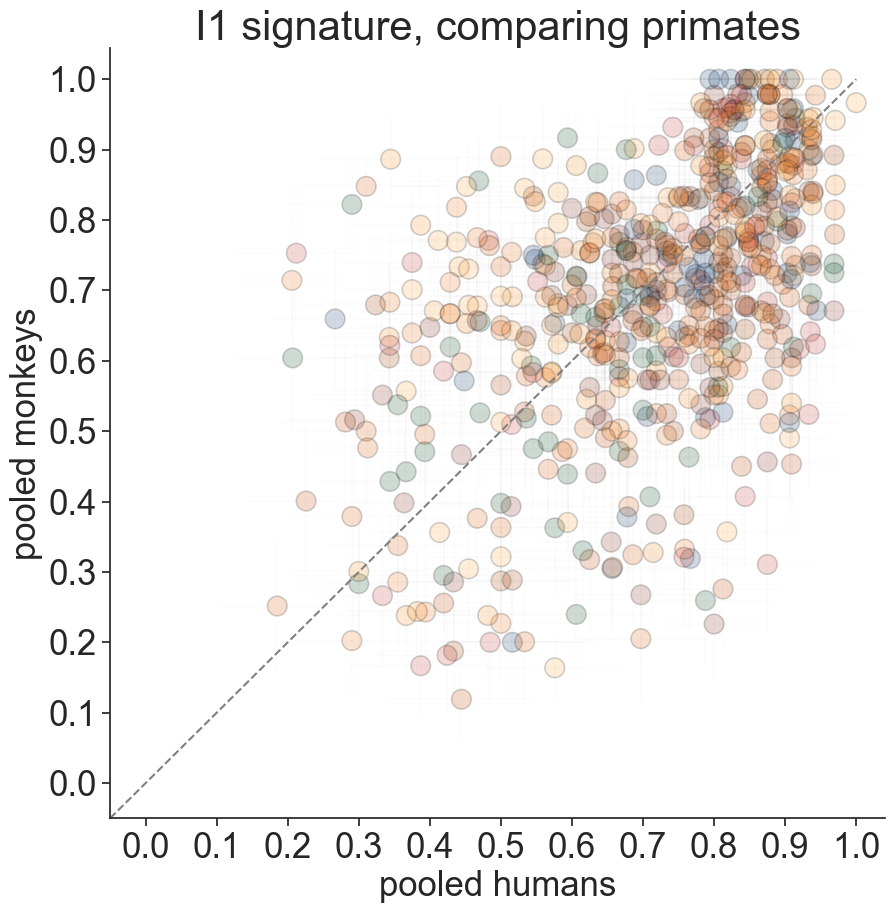

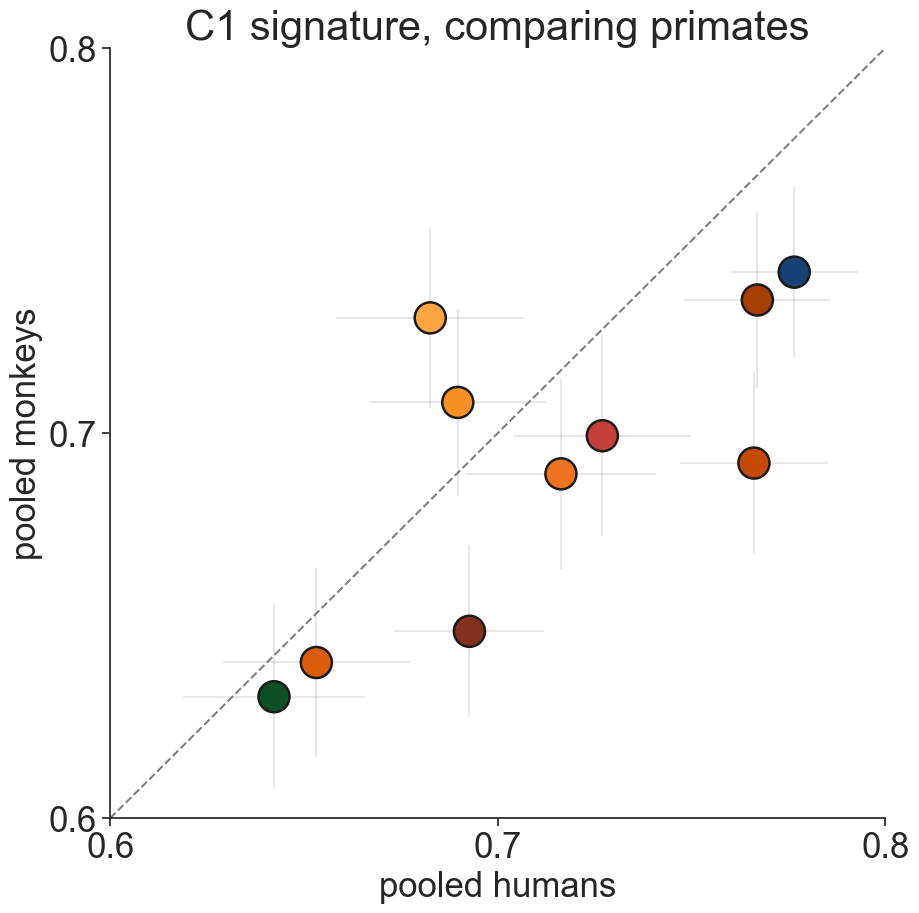

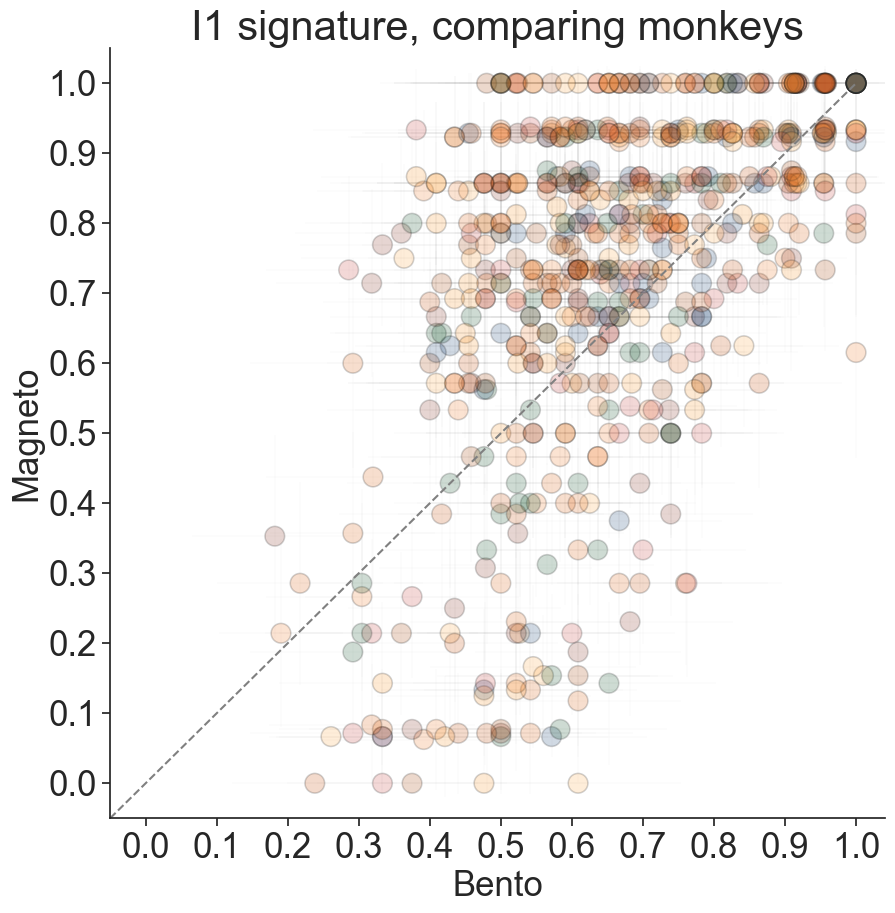

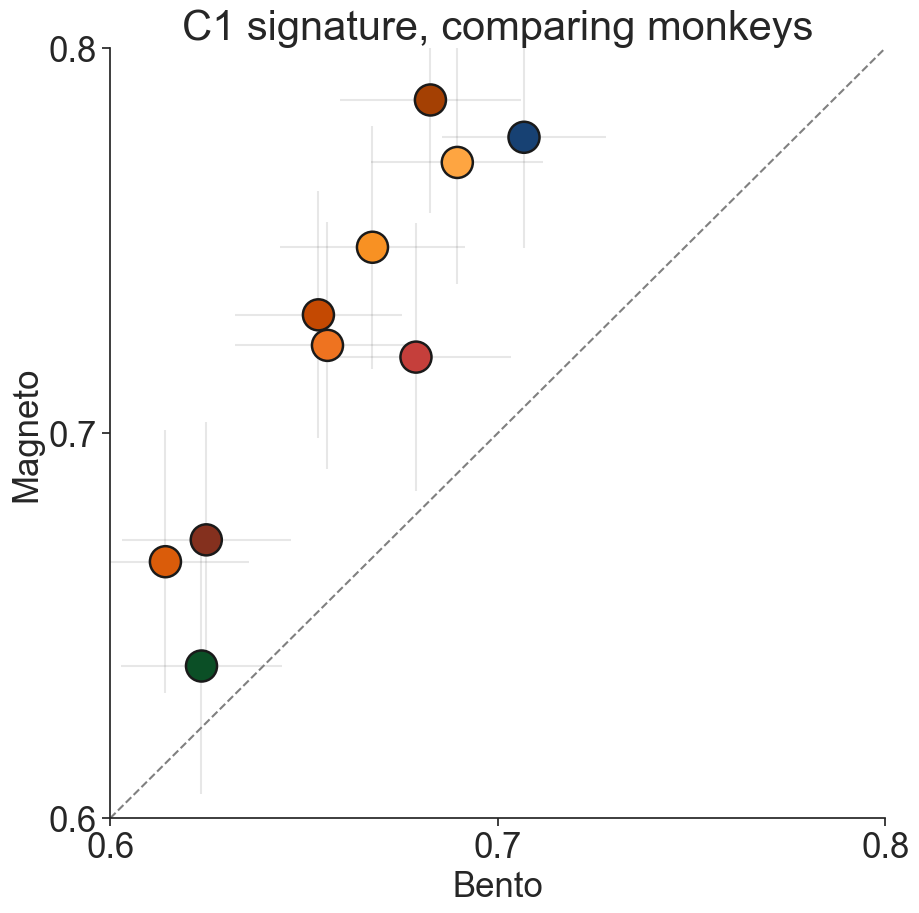

In [9]:
for compare in ['primates', 'monkeys']:

    x_label, y_label = ('pooled humans', 'pooled monkeys') if compare == 'primates' else ('Bento', 'Magneto')
    x_subj, y_subj = (human_metrics, monkey_metrics) if compare == 'primates' else (bento_metrics, magneto_metrics)
    for signature in ['I1', 'C1']:
        monkey_human = pd.DataFrame(np.stack((x_subj[signature][0], y_subj[signature][0]), axis=1))
        monkey_human.columns=[x_label, y_label]

        limit_l = -0.05 if signature =='I1' else 0.6
        limit_r=None if signature =='I1' else 0.8
        ax = sns.scatterplot(data=monkey_human, x=x_label, y=y_label, s=200 if signature == 'I1' else 500, alpha=0.2 if signature == 'I1' else 1,c=repeated_and_flattened_list if signature =='I1' else combined_palette, edgecolor='k')
        ax.set_ylim(limit_l,limit_r)
        ax.set_xlim(limit_l,limit_r)

        tick_loc=0.1
        ax.yaxis.set_major_locator(MultipleLocator(tick_loc))
        ax.xaxis.set_major_locator(MultipleLocator(tick_loc))


        plt.errorbar(monkey_human[x_label], monkey_human[y_label], xerr=x_subj[signature][1], yerr=y_subj[signature][1], zorder=0,fmt='none', color='k', alpha=0.1 if signature == 'C1' else 0.01)
        plt.tick_params(axis='y', labelsize=TICKS_SIZE) 

        plt.tick_params(axis='x', labelsize=TICKS_SIZE) 

        sns.despine()
        ax.set_xlabel(x_label, fontsize=LABEL_SIZE)
        ax.set_ylabel(y_label, fontsize=LABEL_SIZE)

        plt.plot([limit_l, 1], [limit_l, 1], color='grey', linestyle='--', )
        #plt.savefig(f'{compare}_{signature}_both_comparison.eps')
        #plt.savefig(f'{compare}_{signature}_both_comparison.pdf')
        ax.set_title(signature + ' signature, comparing ' + compare, fontsize=LABEL_SIZE+5)
        plt.show()


In [19]:
signature_primates = pd.read_pickle('results/behavioral_signatures_primates.pkl')
self_consistency =pd.read_pickle('results/self-consistency.pkl')



In [20]:
signature_primates = pd.read_pickle('results/behavioral_signatures_primates.pkl')
for signature in ['I1', 'C1']:
    signature_primates[signature]['mean monkeys'] = (np.array(signature_primates[signature]['Bento'])+np.array(signature_primates[signature]['Magneto']))/2



In [21]:
import random
compare='monkeys'
corr_monkey_human=dict()
for signature in ['I1', 'C1']:
    corr_monkey_human[signature]={'mean monkeys':[], 'pooled monkeys':[], 'pooled mean monkeys':[],}
    N = np.array(signature_primates[signature]['humans']).shape[0]
    indices = list(range(N))
    for seed in range(10):
        random.seed(seed)
        random.shuffle(indices)
        c1_list=indices.copy()
        c1_list.remove(seed)
        # Split the list into two non-overlapping sublists
        idx1, idx2 = (indices[:N//2], indices[N//2:])# if signature == 'I1' else (c1_list, c1_list)
        df_monkey_human = pd.DataFrame(signature_primates[signature]).drop(columns=['primates']) 
        corr_monkey_human[signature]['pooled monkeys'].append(df_monkey_human.iloc[idx1].corr()['humans']['monkeys']/self_consistency['mean monkeys'][signature][0])
        corr_monkey_human[signature]['pooled monkeys'].append(df_monkey_human.iloc[idx2].corr()['humans']['monkeys']/self_consistency['mean monkeys'][signature][0])
        corr_monkey_human[signature]['pooled mean monkeys'].append(df_monkey_human.iloc[idx1].corr()['humans']['mean monkeys']/self_consistency['mean monkeys'][signature][0])
        corr_monkey_human[signature]['pooled mean monkeys'].append(df_monkey_human.iloc[idx2].corr()['humans']['mean monkeys']/self_consistency['mean monkeys'][signature][0])
        corr_magneto1, corr_magneto2 = df_monkey_human.iloc[idx1].corr()['humans']['Magneto']/self_consistency['Magneto'][signature][0], df_monkey_human.iloc[idx2].corr()['humans']['Magneto']/self_consistency['Magneto'][signature][0]
        corr_bento1, corr_bento2 = df_monkey_human.iloc[idx1].corr()['humans']['Bento']/self_consistency['Bento'][signature][0], df_monkey_human.iloc[idx2].corr()['humans']['Bento']/self_consistency['Bento'][signature][0]
        corr_monkey_human[signature]['mean monkeys'].append((corr_magneto1+corr_bento1)/2)
        corr_monkey_human[signature]['mean monkeys'].append((corr_magneto2+corr_bento2)/2)






In [22]:
to_plot={}
for signature in ['I1','C1']:
    df_corr_monkey_human = pd.DataFrame(corr_monkey_human[signature])
    mean =df_corr_monkey_human.mean()
    std= df_corr_monkey_human.std()

    to_plot[signature] = pd.DataFrame(mean, columns=['corrected Pearson R']).drop(index='pooled monkeys')

    #to_plot[signature]['corrected Pearson R'] = 
    to_plot[signature]['EV']=to_plot[signature]['corrected Pearson R']**2*100
    to_plot[signature]['std'] = std*100


In [25]:
from scipy.stats import spearmanr
def get_splithalf_corr(data, num_seeds=10):
    # Calculate split-half correlation for 100 seeds
    
    print(f'Number of images: {data.shape[0]}, number of trials: {data.shape[1]}')
    split_half_correlation = { 'I1': np.zeros((num_seeds)),
                               'C1': np.zeros((num_seeds))}
    nb_trials = data.shape[1]
    splits=iter(np.array([
    [
        np.random.seed(seed), 
        np.random.permutation(nb_trials)[:int(nb_trials//2)],
        np.random.seed(seed),
        np.random.permutation(nb_trials)[int(nb_trials//2):]
    ][1::2] for seed in range(num_seeds)]).reshape((num_seeds*2, int(nb_trials//2)) ))
    for i in range(num_seeds):

        sh1, sh2 = data[:,next(splits)].mean(axis=1), data[:,next(splits)].mean(axis=1)
        i1_shc=np.corrcoef(sh1, sh2)[0,1]
        i1_shc=(2*i1_shc)/(1+i1_shc)
        split_half_correlation['I1'][i] = i1_shc
        
        c1_sh1 = np.array([sh1[k::NB_CONTEXT_TYPES].mean(axis=0) for k in range(NB_CONTEXT_TYPES)])
        c1_sh2 = np.array([sh2[k::NB_CONTEXT_TYPES].mean(axis=0) for k in range(NB_CONTEXT_TYPES)])
        c1_shc=np.corrcoef(c1_sh1, c1_sh2)[0,1]
        c1_shc=(2*c1_shc)/(1+c1_shc)
        split_half_correlation['C1'][i] = c1_shc 
        

    print(f"Average split-half correlation across {num_seeds} seeds I1: {np.nanmean(split_half_correlation['I1']):.4f} C1: {np.nanmean(split_half_correlation['C1']):.4f}")
    return split_half_correlation 

In [26]:
valid_trials_per_sbj['humans'].shape

(600, 24)

In [27]:
# Split the human valid trials into 2 * 12 trials per image and use one pool
# for the self-consistency band and the other for the pseudo human increasing population.
humans_popul=valid_trials_per_sbj['humans'][:,12:]

# Number of subjects
num_subjects = 6

# Number of trials per subject
trials_per_subject = 10

result_shape = (humans_popul.shape[0], trials_per_subject)

subjects_data = np.empty((num_subjects,) + result_shape)

# Seed for reproducibility
np.random.seed(42)

# Create subjects
for subject_idx in range(num_subjects):
    # Choose trials with repetition for each image (10 out of 12 trials chosen with rep)
    subjects_data[subject_idx] = np.array([np.random.choice(humans_popul[img], size=10, replace=True) for img in range(600)])

# Now subjects_data contains the data for each subject
# subjects_data[subject_idx] has shape (600, 10) for each subject

subj_I1=[subjects_data[i].mean(axis=1) for i in range(6)]


self_consistency_subjects=[get_splithalf_corr(subjects_data[subj], num_seeds=100) for subj in range(6)]



Number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6862 C1: 0.8618
Number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6814 C1: 0.8683
Number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6927 C1: 0.8838
Number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7189 C1: 0.8911
Number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7060 C1: 0.9078
Number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7124 C1: 0.8869


In [29]:
import numpy as np
from itertools import combinations
humans_popul=valid_trials_per_sbj['humans'][:,12:]
self_consistency_band_humans = get_metrics(valid_trials_per_sbj['humans'][:,:12].mean(axis=1),valid_trials_per_sbj['humans'][:,:12])


subj_I1=[subjects_data[i].mean(axis=1) for i in range(6)]
# Assuming you have an array of behavioral signatures for each subject
signature='I1'
all_means={'I1':{}, 'C1':{}}
#all_means[1]=[np.corrcoef(get_metrics(humans_popul[:,i:i+2])[signature][0],self_consistency_band_humans[signature][0])[0,1] for i in range(0,12,2)]
# Calculate mean for each combination of subjects
all_subjects = list(range(len(subj_I1)))
for signature in ['I1', 'C1']:
    for r in range(1, len(all_subjects) + 1):
        all_means[signature][r]=[]
        for combo in combinations(all_subjects, r):
            #combo_key = '_'.join(combo)
            combo_data = [subj_I1[subject] for subject in combo]
            self_cons=[np.nanmean(self_consistency_subjects[subject][signature]) for subject in combo]
            combo_mean = np.mean(combo_data, axis=0)
            self_cons_mean=np.nanmean(self_cons, axis=0)
            #print(combo_mean.shape)
            # Store or process the combo_key and combo_mean as needed
            print(f'Mean for combination {combo}:')
            subj_i=get_metrics(np.array(combo_data).T.mean(axis=1),np.array(combo_data).T)

            #print(subj_i[signature])
            corr_coef = np.corrcoef(subj_i[signature][0],self_consistency_band_humans[signature][0])[0,1]
            all_means[signature][r].append((corr_coef**2)/self_cons_mean)

Mean for combination (0,):
Mean for combination (1,):
Mean for combination (2,):
Mean for combination (3,):
Mean for combination (4,):
Mean for combination (5,):
Mean for combination (0, 1):
Mean for combination (0, 2):
Mean for combination (0, 3):
Mean for combination (0, 4):
Mean for combination (0, 5):
Mean for combination (1, 2):
Mean for combination (1, 3):
Mean for combination (1, 4):
Mean for combination (1, 5):
Mean for combination (2, 3):
Mean for combination (2, 4):
Mean for combination (2, 5):
Mean for combination (3, 4):
Mean for combination (3, 5):
Mean for combination (4, 5):
Mean for combination (0, 1, 2):
Mean for combination (0, 1, 3):
Mean for combination (0, 1, 4):
Mean for combination (0, 1, 5):
Mean for combination (0, 2, 3):
Mean for combination (0, 2, 4):
Mean for combination (0, 2, 5):
Mean for combination (0, 3, 4):
Mean for combination (0, 3, 5):
Mean for combination (0, 4, 5):
Mean for combination (1, 2, 3):
Mean for combination (1, 2, 4):
Mean for combinatio

In [30]:
mean = pd.DataFrame(all_means).applymap(np.nanmean)
std = pd.DataFrame(all_means).applymap(np.nanstd)

pseudo_humans_increasing = pd.concat((mean, std), axis=1)
pseudo_humans_increasing.columns=['mean I1', 'mean C1', 'std I1', 'std C1']
pseudo_humans_increasing=pseudo_humans_increasing.reset_index().drop(columns=['index'])
pseudo_humans_increasing

,mean I1,mean C1,std I1,std C1
0,0.350244,0.918185,0.036856,0.073147
1,0.411352,0.941821,0.027401,0.050106
2,0.436841,0.949550,0.020543,0.036412
3,0.450828,0.953388,0.014966,0.026130
4,0.459665,0.955682,0.009637,0.016680
5,0.465754,0.957208,0.000000,0.000000


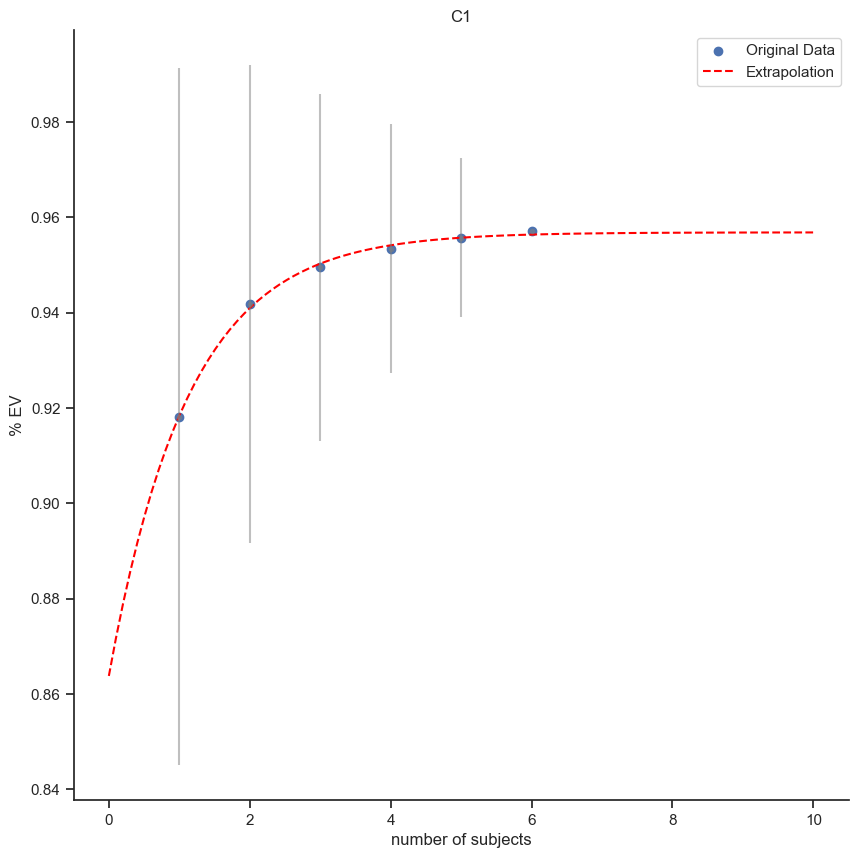

In [31]:
from scipy.optimize import curve_fit


sns.set(rc={"figure.figsize":(10, 10)})
sns.set_theme(style="white"), sns.set_style('ticks') 
def sigmoid(x, a1, b1, c1, d):
        sigmoid1 = a1 / (1 + np.exp(-(x - b1)/c1))
        return sigmoid1+d
def log_funct(x, a, b):
    return a * np.log(x) + b
signature='C1'
x_data=list(range(1,7))
y_data=pseudo_humans_increasing[f'mean {signature}']


def extrapolate(x_data, y_data, signature, funct=sigmoid, end=10, plot=False):


    params, covariance = curve_fit(funct, x_data,y_data ,maxfev = 5000000)
    std_data=pseudo_humans_increasing[f'std {signature}']
    loss = np.sum((y_data - funct(x_data, *params)) ** 2)



    x_extrapolated = np.linspace(0, end, 100)  # Adjust the range as needed
    y_extrapolated = funct(x_extrapolated, *params)
    if plot:
        plt.scatter(x_data, y_data, label='Original Data')
        plt.plot(x_extrapolated, y_extrapolated, label='Extrapolation', linestyle='--', color='red')
        plt.errorbar(x_data,y_data, yerr=std_data, alpha=0.5, c='gray', fmt='.')

        #plt.xscale('log')
        plt.legend()
        plt.xlabel('number of subjects')
        plt.ylabel('% EV')
        plt.title(signature)
        sns.despine()
        plt.show()
    return x_extrapolated, y_extrapolated
x_data=list(range(1,7))
y_data=pseudo_humans_increasing[f'mean {signature}']


x_extrapolated, y_extrapolated =extrapolate(x_data, y_data, signature, plot=True)

In [36]:
def plot_consistency_result(to_plot, y_str, subject_name, signature =None, xlabel="", ylabel="", ratio=8, ylim=None, save_str = None, kde = True):    
    
    sns.set_theme(style="white"), sns.set_style('ticks') 

    df_humans =pseudo_humans_increasing*100#
    df_humans=df_humans.reset_index()
    x_data=df_humans['index'].values
    # Shift to the line (by subtracting the delta: human consistency-shared EV[])
    y_data=df_humans[f'mean {signature}'].values-(df_humans[f'mean {signature}'].values[1]-to_plot['EV'][1]) 

    x_extrapolated, y_extrapolated =extrapolate(x_data, y_data, signature, end=6, plot=False)
    
    g = sns.JointGrid(height=16, ratio=6)
    ax = sns.barplot(data=to_plot, x=to_plot.index, y=y_str,estimator=np.mean, ec="black", linewidth=1.5,
                 ax=g.ax_joint, palette='Greys')
    ax_humans =sns.scatterplot(ax=ax, data=df_humans, x='index', y=f'mean {signature}', c='k', s=200)
    ax_humans.errorbar( x=df_humans['index'], y= df_humans[f'mean {signature}'], yerr= df_humans[f'std {signature}'], alpha=0.1)
    ax_humans.plot(x_extrapolated, y_extrapolated, label='Extrapolation', linestyle='--', color='red')

    if kde:
        self_reliability=self_consistency[subject_name][signature]
        # Plotting the self-consistency band with the margin kde distribution
        g.ax_joint.axhspan(ymin=(np.array(self_reliability[0]-self_reliability[1])**4)*100, 
                   ymax=(np.array(self_reliability[0]+self_reliability[1])**4)*100, 
                   color='teal', alpha=0.5, label='self consistency')
        sns.kdeplot(y=(np.array(self_reliability[4])**4)*100, linewidth=2, ax=g.ax_marg_y, 
                    c='k', label='self consistency', alpha=0.75, common_norm=True)

    g.ax_joint.set_xticks(list(range(len(to_plot.index))), to_plot.index, rotation=0,fontsize=15)
    # add errorbars
    patches = g.ax_joint.patches[:-1] if kde else g.ax_joint.patches[:]
    x_coords = [p.get_x() + 0.5 * p.get_width() for p in patches]
    y_coords = [p.get_height() for p in patches]
    ax.errorbar(x=x_coords[:], y=y_coords[:], yerr=to_plot["std"][:], fmt="o", c="k")
    FONT_SIZE=25
    ax.tick_params(axis='y', labelsize=FONT_SIZE) 
    ax.tick_params(axis='x', labelsize=FONT_SIZE) 
    g.ax_marg_x.remove()
    plt.ylim(ylim)
    ax.set_xlabel(xlabel, fontsize=FONT_SIZE, labelpad=11)
    ax.set_ylabel(ylabel, fontsize=FONT_SIZE)
    ax.set_xticklabels(['monkeys\nn=1','monkeys\nn=2'])
    plt.tight_layout()
    ax.set_title(signature,fontsize=FONT_SIZE)
    if save_str != None:
        plt.savefig(f'{save_str}.eps')




/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_3867/1595198417.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=to_plot, x=to_plot.index, y=y_str,estimator=np.mean, ec="black", linewidth=1.5,
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_3867/1595198417.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=to_plot, x=to_plot.index, y=y_str,estimator=np.mean, ec="black", linewidth=1.5,
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


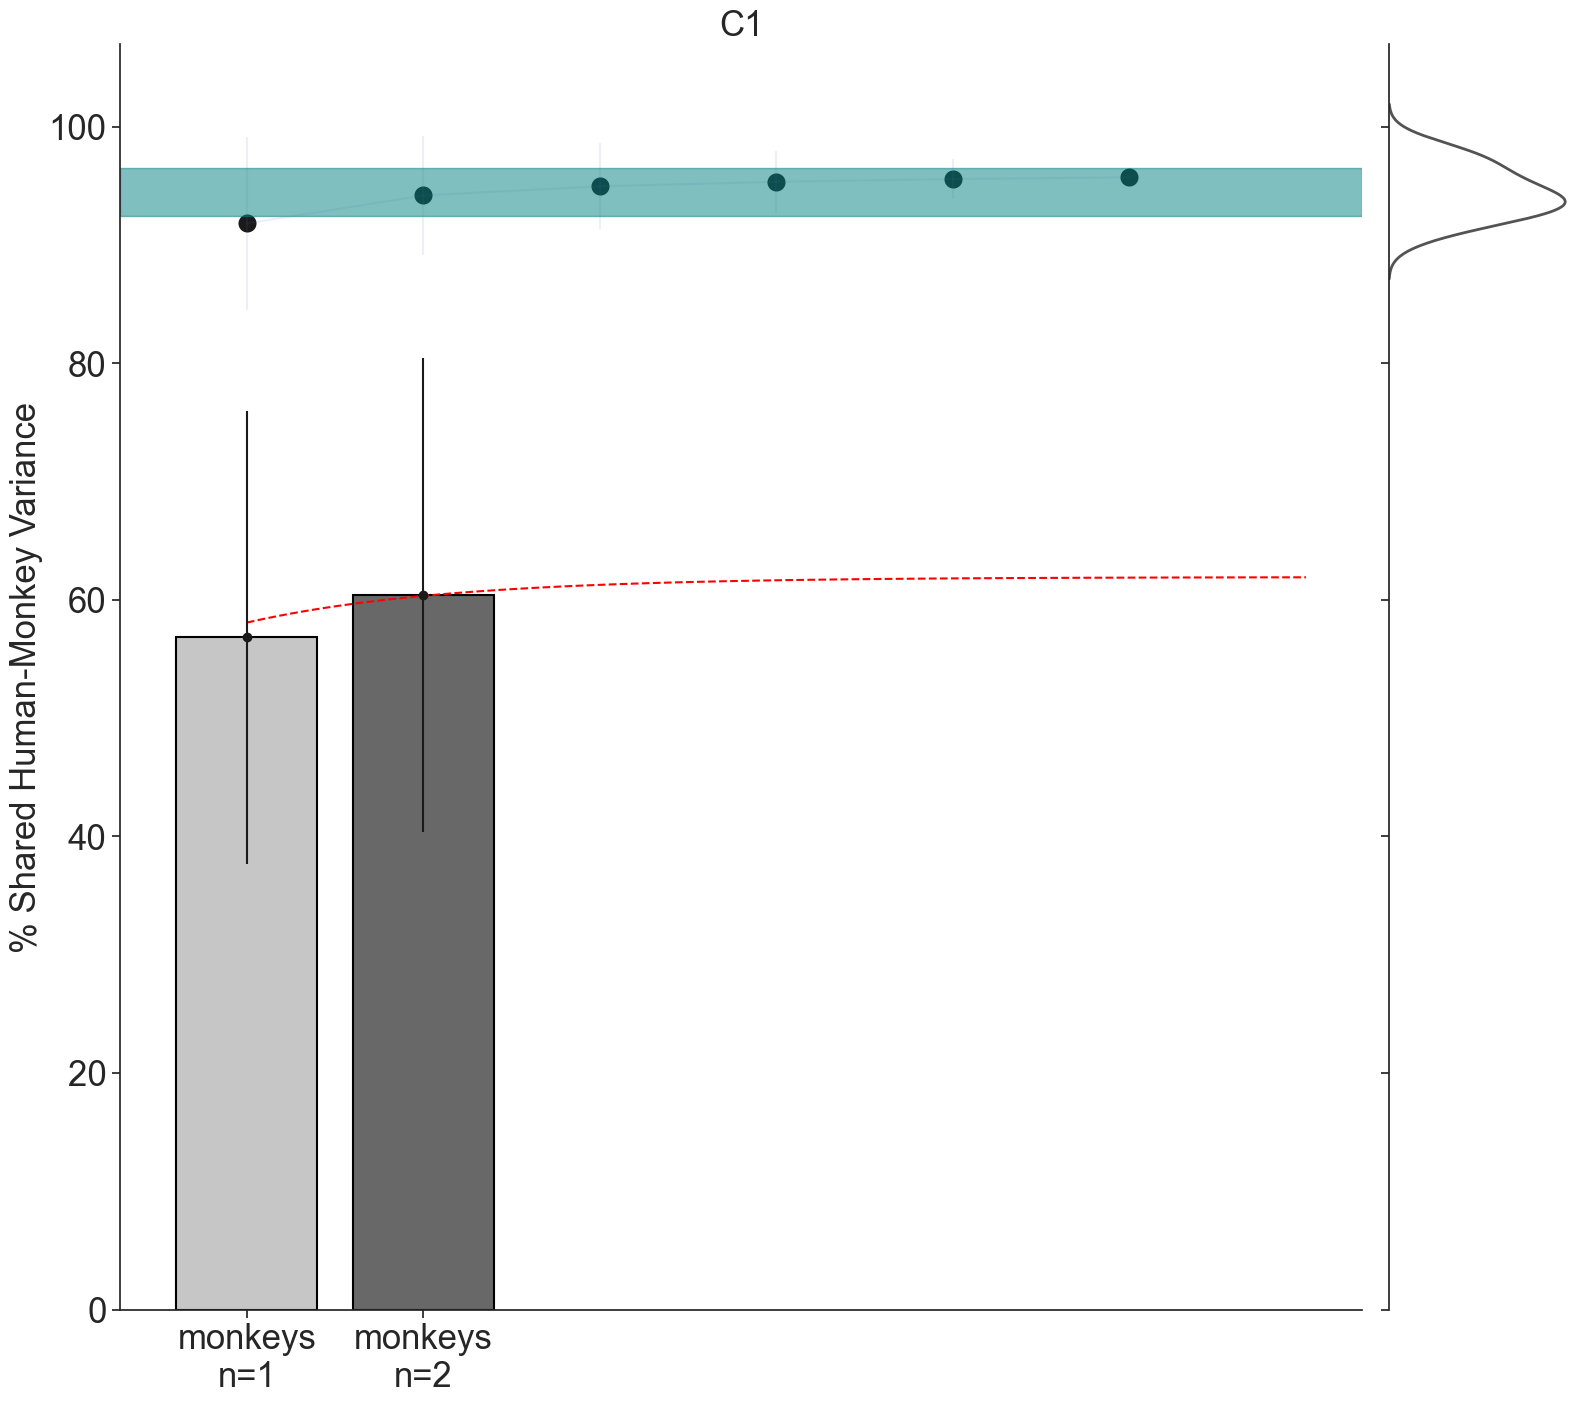

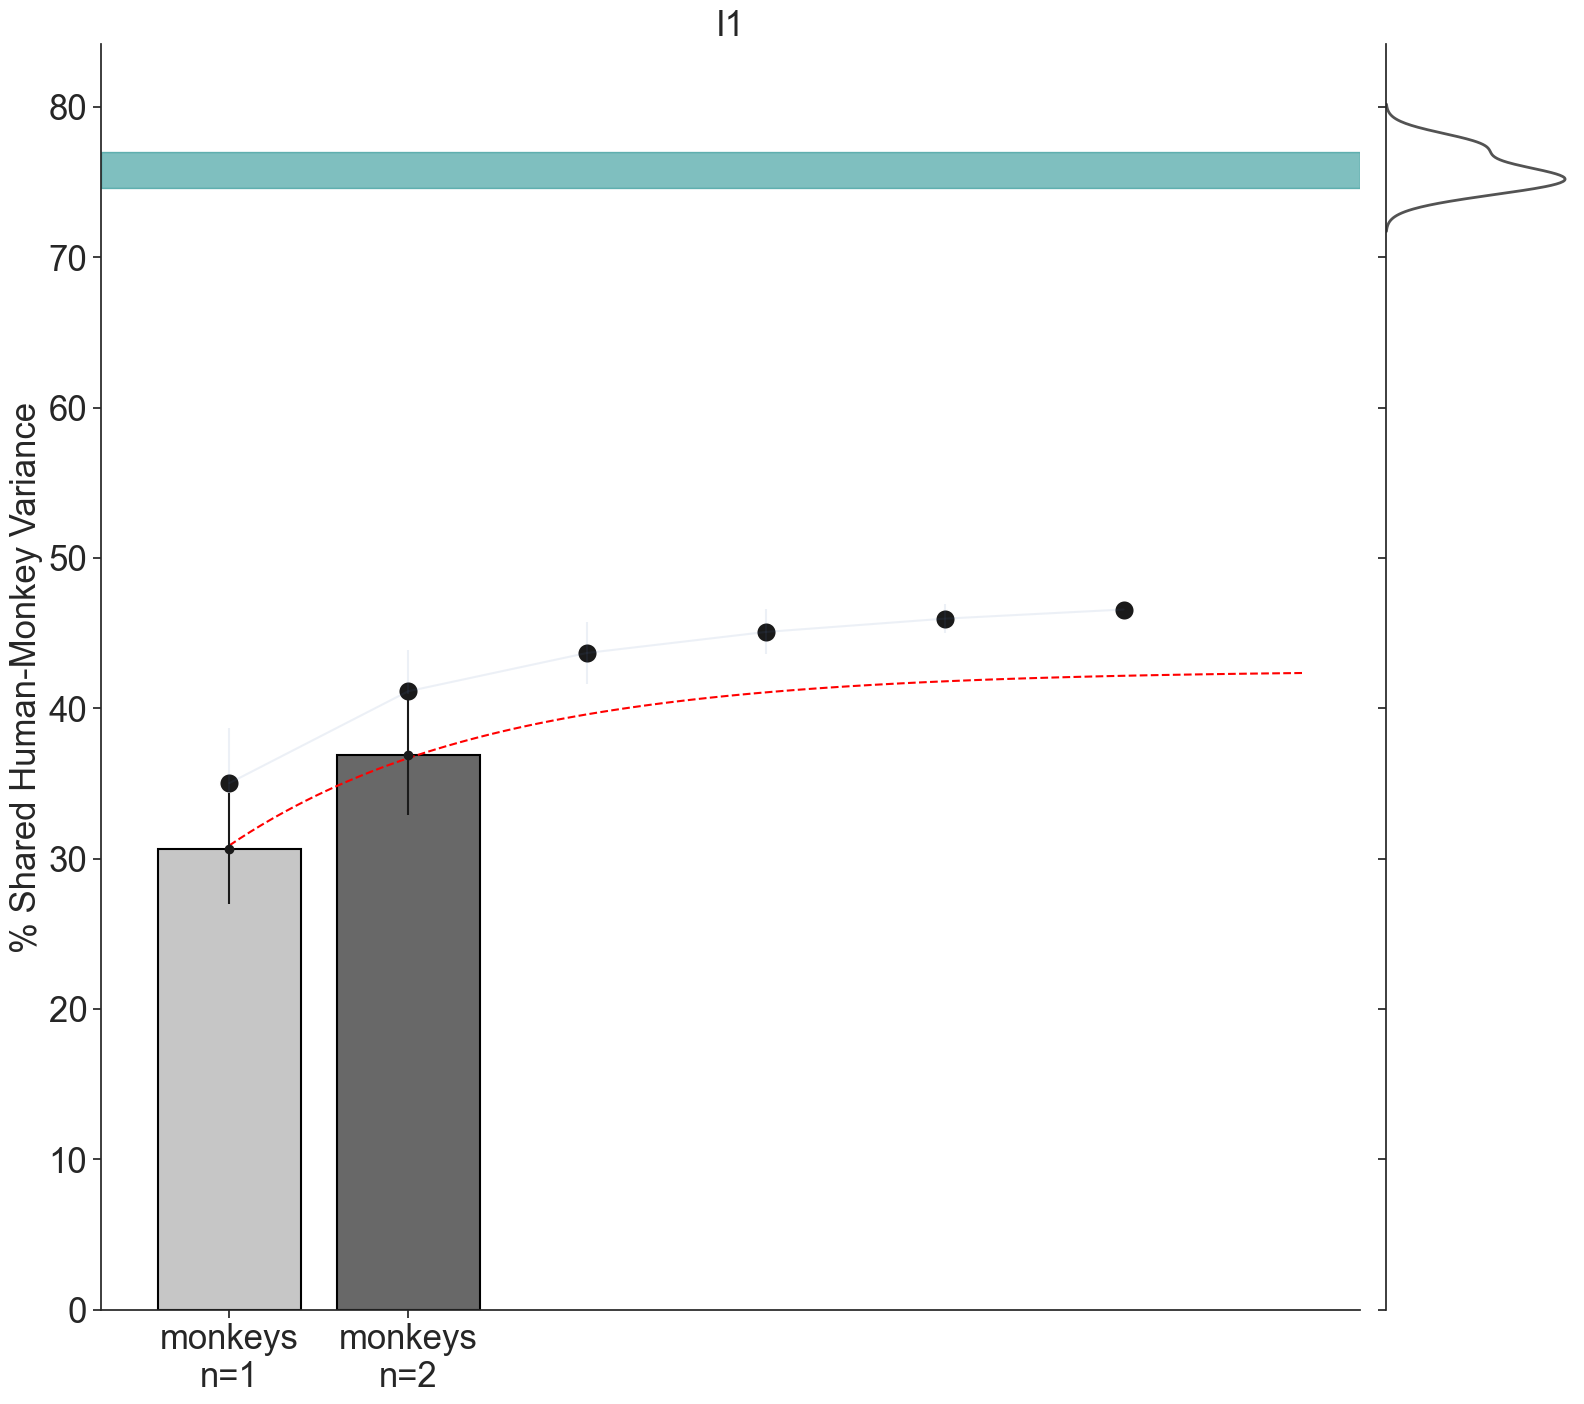

In [37]:
for signature in ['C1', 'I1']:
    plot_consistency_result(to_plot[signature], 'EV', subject_name='primates', ylabel='% Shared Human-Monkey Variance', save_str=f'shared_var_human_monkey_{signature}',signature=signature, kde=True)

